# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Ипорт библиотек

In [1]:
#conda install -c conda-forge lightgbm

In [2]:
#!pip3 install catboost
!pip install phik

     |████████████████████████████████| 686 kB 1.1 MB/s eta 0:00:01


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import time

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder 
from catboost import CatBoostRegressor 
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [4]:
autos=pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv',sep=',')

In [5]:
def dataset_info(dataset,name):
    display(f'Анализ датафрейма {name}')
    display(dataset.head(5))
    display(f'Количество пустых ячеек:')
    display(dataset.isnull().sum())
    display(dataset.info())
    display(f'Количество явных дубликатов в датасете:{dataset.duplicated().sum()}' )
    dataset=dataset.drop_duplicates()
    display(f'Количество явных дубликатов в датасете после удаления:{dataset.duplicated().sum()}' )


In [6]:
dataset_info(autos, 'autos')

'Анализ датафрейма autos'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'Количество пустых ячеек:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

'Количество явных дубликатов в датасете:4'

'Количество явных дубликатов в датасете после удаления:0'

###  Выводы
По результатам загрузки файла можно сделать выводы, что требуется изменение форматов некоторых столбцов, присутствуют явные дубликаты (удалены 4шт), большое количество пустых ячеек (предварительно пока строки с ними удалять не будем, а далее заменим наиболее часто встречающимся в категории бренда)

In [7]:
def graphs(dataset,name):
    display(f'Анализ количественных признаков датафрейма {name}')
    display(dataset.describe())
    for j in dataset.columns:
        if dataset[j].dtype!=object:
            fig = plt.hist(dataset[j],color = 'blue', edgecolor = 'black',bins = 50)
            plt.xlabel(j)
            plt.ylabel('Количество')
            plt.title(f'Анализ столбца {j}',fontweight = "bold")
            plt.show()
            dataset.boxplot([j])
            plt.title(f'Boxplot для  столбца {j}')
            plt.show()

'Анализ количественных признаков датафрейма autos'

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


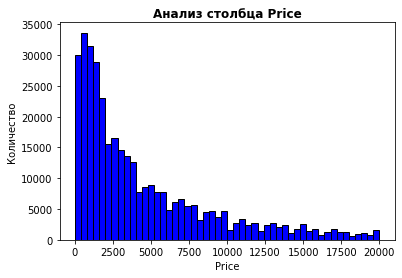

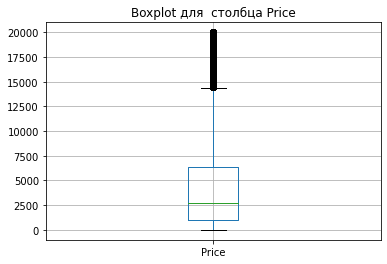

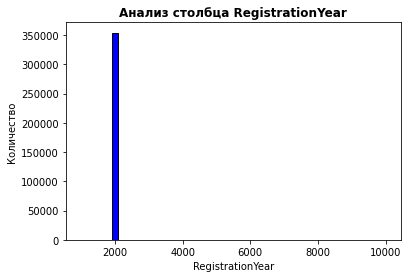

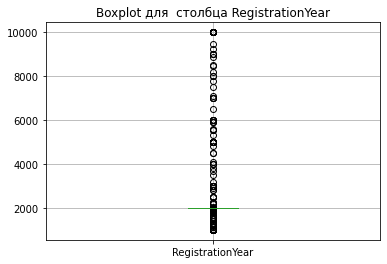

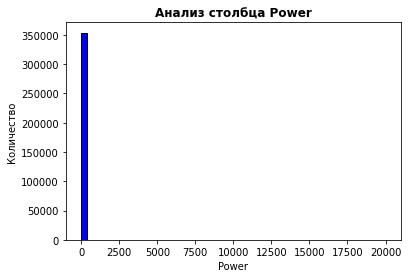

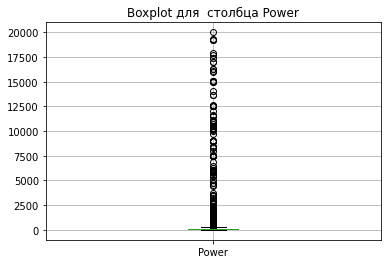

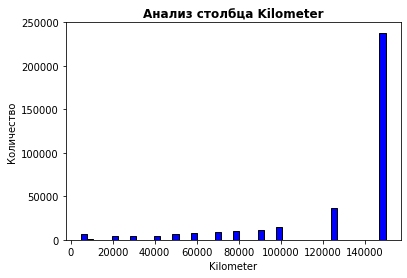

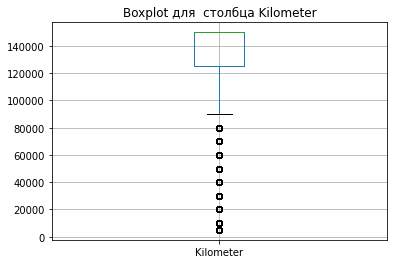

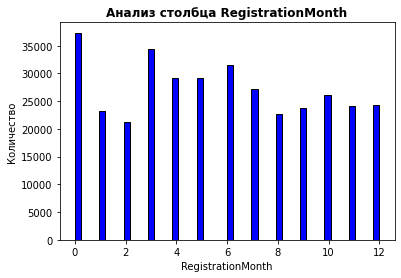

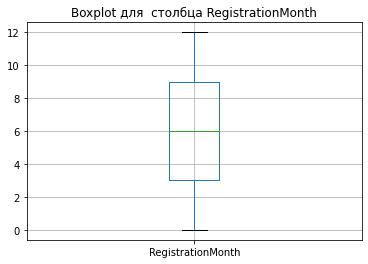

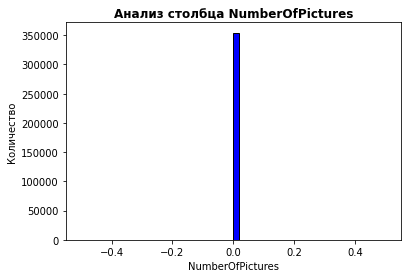

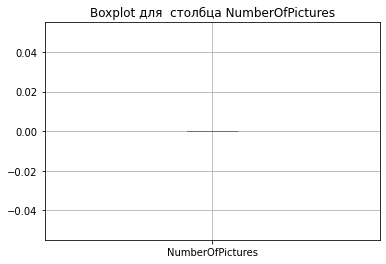

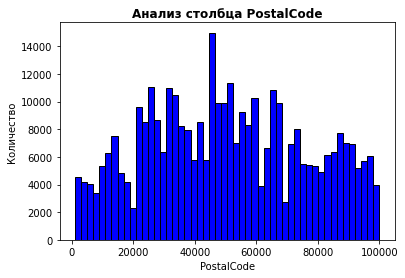

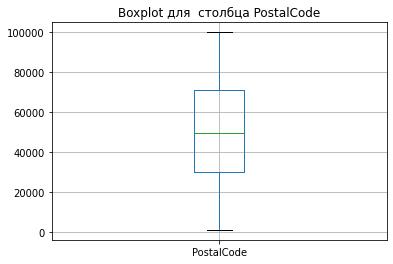

In [8]:
graphs(autos, 'autos')

###  Выводы
В датафрейме присутствуют обьявления без цены ,мощностью более 1500,годом регистрации старшее 2024, столбец 'NumberOfPictures' не содержит уникальных значений. Удалим данные аномалии

In [9]:
autos = autos.drop(autos[autos['Price']==0].index)

In [10]:
autos=autos.reset_index()
autos['DateCreated'] = pd.to_datetime(autos['DateCreated']).dt.normalize()
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled']).dt.normalize()
for i in range(len(autos)):
    if autos.loc[i,'DateCrawled']<autos.loc[i,'DateCreated']:
        autos.loc[i,'DateCreated'] = autos.loc[i,'DateCrawled']
    if pd.DatetimeIndex([autos.loc[i,'DateCrawled']]).year <=autos.loc[i,'RegistrationYear']:
        autos.loc[i,'RegistrationYear']=pd.DatetimeIndex([autos.loc[i,'DateCrawled']]).year
autos = autos.drop(autos[autos['RegistrationYear']<1980].index)

In [11]:
autos = autos.drop(autos[autos['Power']>1500].index)
autos=autos.drop('NumberOfPictures',axis=1).reset_index()

In [12]:
autos = autos.drop(autos[autos['Power']==0].index)

In [13]:
list_category=['Model','Gearbox','Power','VehicleType','FuelType','Repaired']
list_of_brand=autos['Brand'].unique()
for i in list_category:
    data_brand=pd.DataFrame()
    temp=pd.pivot_table(autos.query("Power!=0"),index=['Brand',i],values=['DateCrawled'],aggfunc='count').reset_index()
    for j in list_of_brand:
        data_brand=pd.concat([data_brand,temp.query('Brand==@j').sort_values(by='DateCrawled',ascending=False).head(1)])
    data_brand=data_brand.reset_index()
    for k in range(len(data_brand)):
        autos.loc[(autos['Brand']==data_brand.loc[k, "Brand"]) & (autos[i].isnull()), i] = data_brand.loc[k, i]

In [14]:
dataset_info(autos, 'autos')

'Анализ датафрейма autos'

,level_0,index,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
1,1,1,2016-03-24,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2,2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,90480,2016-04-05 12:47:46
3,3,3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,4,4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
5,5,5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07


'Количество пустых ячеек:'

level_0                 0
index                   0
DateCrawled             0
Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                1529
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
Repaired                0
DateCreated             0
PostalCode              0
LastSeen                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304823 entries, 1 to 340245
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   level_0            304823 non-null  int64         
 1   index              304823 non-null  int64         
 2   DateCrawled        304823 non-null  datetime64[ns]
 3   Price              304823 non-null  int64         
 4   VehicleType        304823 non-null  object        
 5   RegistrationYear   304823 non-null  int64         
 6   Gearbox            304823 non-null  object        
 7   Power              304823 non-null  int64         
 8   Model              303294 non-null  object        
 9   Kilometer          304823 non-null  int64         
 10  RegistrationMonth  304823 non-null  int64         
 11  FuelType           304823 non-null  object        
 12  Brand              304823 non-null  object        
 13  Repaired           304823 non-null  object  

None

'Количество явных дубликатов в датасете:0'

'Количество явных дубликатов в датасете после удаления:0'

###  Выводы
В пустые ячейки внесены значения, наиболее встречающиеся для каждого бренда. 

In [15]:
autos['Model']=autos['Model'].fillna('unknown')

In [16]:
autos = autos.drop(['DateCreated','DateCrawled','LastSeen'],axis=1)

In [17]:
autos=autos.drop('index',axis=1)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable PostalCode is large: 8118. Are you sure this is not an interval variable? Analysis for pairs of variables including PostalCode can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2021382. Are interval variables set correctly?
  warnings.warn(


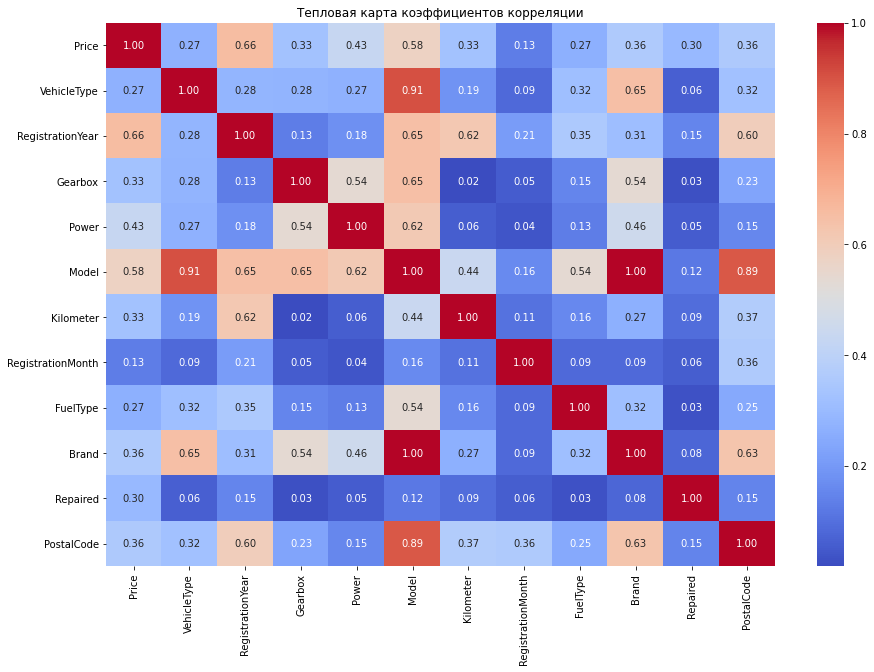

In [18]:
autos=autos.drop('level_0',axis=1)

interval_cols = ['Price', 'Power'] 
phik_matrix = autos.phik_matrix(interval_cols =interval_cols)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Тепловая карта коэффициентов корреляции")
plt.show()

###  Выводы

По тепловой карте коэффициентов корреляции можно сделать вывод, что наименьшее влияние на цену оказывают почтовый индекс и месяц регистрации. Наибольшее влияние оказывает год регистрации и модель автомобиля

## Обучение моделей

In [19]:
RANDOM_STATE=42
TEST_SIZE=0.2
data_ML=autos[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired']].copy().drop_duplicates()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    data_ML.drop('Price', axis=1),
    data_ML['Price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = TEST_SIZE, 
random_state = RANDOM_STATE)

numbers = data_ML.drop('Price', axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
categories = data_ML.drop('Price', axis=1).select_dtypes(include=['object']).columns.tolist()


encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ohe = encoder.fit_transform(X_train[categories])
X_test_ohe = encoder.transform(X_test[categories])
X_valid_ohe = encoder.transform(X_valid[categories])

encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)

encoder = OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore')
X_train_ohe_lr = encoder.fit_transform(X_train[categories])
X_test_ohe_lr = encoder.transform(X_test[categories])
X_valid_ohe_lr= encoder.transform(X_valid[categories])

encoder_col_names = encoder.get_feature_names_out()
X_train_ohe_lr = pd.DataFrame(X_train_ohe_lr, columns=encoder_col_names)
X_test_ohe_lr= pd.DataFrame(X_test_ohe_lr, columns=encoder_col_names)
X_valid_ohe_lr= pd.DataFrame(X_valid_ohe_lr, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numbers])
X_test_scaled = scaler.transform(X_test[numbers])
X_valid_scaled = scaler.transform(X_valid[numbers])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numbers)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numbers)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=numbers)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

X_train_lr = pd.concat([X_train_ohe_lr, X_train_scaled], axis=1)
X_test_lr = pd.concat([X_test_ohe_lr, X_test_scaled], axis=1)
X_valid_lr= pd.concat([X_valid_ohe_lr, X_valid_scaled], axis=1)


In [21]:
start_time = time.time()

score =[]

for hyperparam1 in [True, False]:
    for hyperparam2 in [True, False]:
        for hyperparam3 in [1, -1]:
            model_LR = LinearRegression(copy_X=hyperparam1,fit_intercept=hyperparam2,n_jobs=hyperparam3)
            model_LR.fit(X_train_lr,y_train)
            target_predict = model_LR.predict(X_valid_lr)
            RMSE_LR = mean_squared_error( y_valid,target_predict) ** 0.5
            score.append((RMSE_LR, hyperparam1, hyperparam2,hyperparam3))
            
best_lr=min(score)

model_LR = LinearRegression(copy_X=best_lr[1],fit_intercept=best_lr[2],n_jobs=best_lr[3])

model_LR.fit(X_train_lr, y_train)

end_time = time.time()

education_time_LR = end_time - start_time

start_time = time.time()
target_predict = model_LR .predict(X_valid_lr)
end_time = time.time()
prediction_time_LR = end_time - start_time
RMSE_LR = mean_squared_error(y_valid,target_predict) ** 0.5

In [22]:
start_time = time.time()
model_DT = DecisionTreeRegressor(criterion='friedman_mse', 
                              max_depth=15, 
                              random_state=RANDOM_STATE) 
model_DT.fit(X_train, y_train)
end_time = time.time()
education_time_DT = end_time - start_time

start_time = time.time()
target_predict = model_DT.predict(X_valid)
end_time = time.time()
prediction_time_DT = end_time - start_time
RMSE_DT = mean_squared_error( y_valid,target_predict) ** 0.5   

In [23]:
start_time = time.time()
model_R = Ridge(solver='svd',random_state=RANDOM_STATE)
model_R.fit(X_train, y_train)
end_time = time.time()
education_time_R = end_time - start_time

start_time = time.time()
target_predict = model_R.predict(X_valid)
end_time = time.time()
prediction_time_R = end_time - start_time
RMSE_R= mean_squared_error( y_valid,target_predict) ** 0.5

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> У модели не настроен `random_state`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправлено
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [24]:
start_time = time.time()
model_CB = CatBoostRegressor(learning_rate=0.5, 
                          random_state=RANDOM_STATE, 
                          verbose=False) 
model_CB.fit(X_train, y_train)
end_time = time.time()
education_time_CB = end_time - start_time

start_time = time.time()
target_predict = model_CB.predict(X_valid)
end_time = time.time()
prediction_time_CB = end_time - start_time
RMSE_CB = mean_squared_error( y_valid,target_predict) ** 0.5

In [25]:
start_time = time.time()
model_LGBM = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=RANDOM_STATE)
model_LGBM.fit(X_train, y_train)
end_time = time.time()
education_time_LGBM = end_time - start_time

start_time = time.time()
target_predict = model_LGBM.predict(X_valid)
end_time = time.time()
prediction_time_LGBM = end_time - start_time
RMSE_LGBM = mean_squared_error( y_valid,target_predict) ** 0.5

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 162503, number of used features: 9
[LightGBM] [Info] Start training from score 4966.662782


###  Выводы
Обучены разные модели: LinearRegression,DecisionTreeRegressor,Ridge,CatBoostRegressor,LightGBM

## Анализ моделей

In [26]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'Ridge',
         'CatBoostRegressor',
        'LGBM']
data = {'RMSE':[RMSE_LR,RMSE_DT,RMSE_R,RMSE_CB,RMSE_LGBM],'education_time':[education_time_LR,education_time_DT,education_time_R,education_time_CB,education_time_LGBM],'prediction_time':[prediction_time_LR,prediction_time_DT,prediction_time_R,prediction_time_CB,prediction_time_LGBM]}
display(pd.DataFrame(data=data, index=index))

,RMSE,education_time,prediction_time
LinearRegression,2728.031446,30.895684,0.015374
DecisionTreeRegressor,1942.083350,0.338446,0.005316
Ridge,3074.944330,0.020987,0.001066
CatBoostRegressor,1641.178342,6.214774,0.012331
LGBM,1639.482417,0.830766,0.096053


In [27]:
start_time = time.time()
target_predict = model_LGBM.predict(X_test)
end_time = time.time()
prediction_time_LGBM_test = end_time - start_time

RMSE_LGBM_test = mean_squared_error( y_test,target_predict) ** 0.5

display('prediction_time_LGBM_test ',prediction_time_LGBM_test)
display('RMSE_LGBM_test ',RMSE_LGBM_test)

'prediction_time_LGBM_test '

0.12260317802429199

'RMSE_LGBM_test '

1628.6731235114025

###  Выводы
По результатам анализа моделей можно сделать вывод, что величина RMSE самая низкая (1639) у LightGBM,  время обучения составляет 0.84. 
Стоит остановить выбор на данной модели. Время выполнения составило 0,11 секунд, RMSE 1628

#  ОБЩИЕ ВЫВОДЫ:

По результатам загрузки файла можно сделать выводы, что требуется изменение форматов некоторых столбцов, присутствуют явные дубликаты (удалены 4шт), большое количество пустых ячеек (предварительно пока строки с ними удалять не будем, а далее заменим наиболее часто встречающимся в категории бренда)

В датафрейме присутствуют обьявления без цены ,мощностью более 1500,годом регистрации старшее 2024, столбец 'NumberOfPictures' не содержит уникальных значений. Удалим данные аномалии

В пустые ячейки внесены значения, наиболее встречающиеся для каждого бренда. 

Обучены разные модели: LinearRegression,DecisionTreeRegressor,Ridge,CatBoostRegressor,LightGBM

По результатам анализа моделей можно сделать вывод, что величина RMSE самая низкая (1639) у LightGBM,  время обучения составляет 0.84. 
Стоит остановить выбор на данной модели. Время выполнения составило 0,11 секунд, RMSE 1628